In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.patches import Polygon
from typing import Dict, Tuple, List, Optional


class ParityWeightedPH2D:
    def __init__(self, points: np.ndarray, max_alpha: Optional[float] = None,
                 lambda_rel: float = 0.03, drop_infinite: bool = True):
        P = np.asarray(points, float)
        assert P.ndim == 2 and P.shape[1] >= 2
        self.XY = P[:, :2]
        self.max_alpha2 = None if max_alpha is None else float(max_alpha)**2
        self.lambda_rel = float(lambda_rel)
        self.drop_inf = bool(drop_infinite)

    # ---------- base alpha complex ----------
    def _alpha_tree(self) -> gd.SimplexTree:
        return gd.AlphaComplex(points=self.XY).create_simplex_tree()

    def _extract_up_to_dim2(self, st: gd.SimplexTree):
        V: Dict[int, float] = {}
        E: Dict[Tuple[int,int], float] = {}
        T: List[Tuple[int,int,int,float]] = []
        for s, a2 in st.get_skeleton(2):
            a2 = float(a2)
            d = len(s) - 1
            if d == 0:
                V[int(s[0])] = a2
            elif d == 1:
                i, j = sorted(map(int, s)); E[(i,j)] = a2
            elif d == 2:
                i, j, k = map(int, s)
                if (self.max_alpha2 is None) or (a2 <= self.max_alpha2):
                    T.append((i,j,k,a2))
        return V, E, T

    @staticmethod
    def _canon_signed_area(tri_xy: np.ndarray) -> float:
        t = np.asarray(tri_xy)
        o = np.lexsort((t[:,1], t[:,0]))
        p0, p1, p2 = t[o]
        v1, v2 = p1-p0, p2-p0
        return v1[0]*v2[1] - v1[1]*v2[0]

        

    # ---------- vertex parity scores ----------
    def _vertex_parity_scores(self, tris_a2):
        # S_v = mean of triangle orientation signs incident at v
        acc = {}   # v -> (sum, cnt)
        for i,j,k,_ in tris_a2:
            tri = self.XY[[i,j,k]]
            s = np.sign(self._canon_signed_area(tri))
            if s == 0:  # degenerate
                continue
            for v in (i,j,k):
                if v in acc: acc[v] = (acc[v][0]+s, acc[v][1]+1)
                else:        acc[v] = (s, 1)
        S = {v: (su/c) for v,(su,c) in acc.items()}
        # vertices with no incident triangles get 0
        return S

    # ---------- normalization helper ----------
    @staticmethod
    def _normalize_values(vals: List[float]):
        lo, hi = min(vals), max(vals)
        span = (hi - lo) if hi > lo else 1.0
        return lo, span

    # ---------- build two parity-weighted filtrations ----------
    def _build_weighted_trees(self):
        st_full = self._alpha_tree()
        V, E, T = self._extract_up_to_dim2(st_full)

        # base α² normalization to [0,1]
        base_vals = [*V.values(), *E.values(), *[a2 for *_, a2 in T]] or [0.0, 1.0]
        lo, span = self._normalize_values(base_vals)

        Vn = {i: (a2 - lo)/span for i,a2 in V.items()}
        En = {e: (a2 - lo)/span for e,a2 in E.items()}
        Tn = [(i,j,k,(a2 - lo)/span) for (i,j,k,a2) in T]

        # vertex parity scores
        Sv = self._vertex_parity_scores(T)

        # simplex parity score = mean vertex score
        def simplex_score(simplex):
            return np.mean([Sv.get(v, 0.0) for v in simplex])

        lam = self.lambda_rel  # absolute in normalized units

        # Build LH and RH trees from the same 1-skeleton but with shifted times
        def build_tree(sign: int):  # sign = +1 => RH, -1 => LH
            st = gd.SimplexTree()
            # vertices
            for v, a2 in Vn.items():
                # tiny bias on vertices (very small) to break ties consistently
                st.insert([v], filtration=max(0.0, a2 - sign*lam*0.05*Sv.get(v,0.0)))
            # edges
            edge_fil = {}
            for (i,j), a2 in En.items():
                s = simplex_score((i,j))
                a2p = max(0.0, a2 - sign*lam*s)
                st.insert([i,j], filtration=a2p)
                edge_fil[(i,j)] = a2p
            # triangles
            for i,j,k,a2 in Tn:
                s = simplex_score((i,j,k))
                a2p = max(0.0, a2 - sign*lam*s)
                # enforce coface ≥ faces
                e1 = edge_fil[tuple(sorted((i,j)))]
                e2 = edge_fil[tuple(sorted((j,k)))]
                e3 = edge_fil[tuple(sorted((i,k)))]
                a2p = max(a2p, e1, e2, e3)
                st.insert([i,j,k], filtration=a2p)
            st.make_filtration_non_decreasing()
            return st

        RH = build_tree(+1)
        LH = build_tree(-1)
        return LH, RH

    # ---------- persistence / plotting ----------
    @staticmethod
    def _pd(st: gd.SimplexTree, drop_inf=True):
        pd = st.persistence()
        return [(d,(b,de)) for d,(b,de) in pd if (not drop_inf) or np.isfinite(de)]

    def chiral_persistence(self):
        LH, RH = self._build_weighted_trees()
        return self._pd(LH, self.drop_inf), self._pd(RH, self.drop_inf)

    @staticmethod
    def _pairs(diag, k): return [bd for d,bd in diag if d==k]

    def bottleneck_distance(self):
        LH, RH = self.chiral_persistence()
        return {k: gd.bottleneck_distance(self._pairs(LH,k), self._pairs(RH,k)) for k in (0,1)}

    def wasserstein_distance(self, q=1.0):
        import gudhi.wasserstein as ws
        LH, RH = self.chiral_persistence()
        def arr(diag,k):
            A = np.array(self._pairs(diag,k), float)
            return A if A.size else np.empty((0,2))
        return {k: ws.wasserstein_distance(arr(LH,k), arr(RH,k), order=q) for k in (0,1)}

    @staticmethod
    def _plot_pd(ax, diag, units="α²"):
        # autoscale
        pts = np.array([bd for _,bd in diag], float) if diag else np.zeros((0,2))
        if pts.size:
            lo, hi = float(np.nanmin(pts)), float(np.nanmax(pts))
            pad = 0.05*(hi - lo + 1e-12)
            xlim = (max(0.0, lo - pad), hi + pad)
            ylim = xlim
        else:
            xlim = ylim = (0.0, 1.0)
        ax.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], 'k-', lw=1.6)
        ax.add_patch(Polygon([[xlim[0],ylim[0]],[xlim[1],ylim[0]],[xlim[1],ylim[1]]],
                             closed=True, facecolor="#d3d3d3", edgecolor="none", alpha=0.6))
        for k,color in [(0,"#e41a1c"),(1,"#377eb8")]:
            A = np.array([bd for d,bd in diag if d==k], float)
            if A.size:
                m = np.isfinite(A[:,1])
                ax.scatter(A[m,0], A[m,1], s=28, alpha=0.75, c=color, edgecolors="none", label=str(k))
        ax.set_xlim(xlim); ax.set_ylim(ylim); ax.set_aspect("equal")
        ax.set_xlabel(f"Birth ({units})"); ax.set_ylabel(f"Death ({units})")
        if any(d==0 or d==1 for d,_ in diag): ax.legend(loc="lower right", title="Dim", framealpha=0.9)

    def plot(self):
        LH, RH = self.chiral_persistence()
        fig, axs = plt.subplots(1,2, figsize=(12,5.2), constrained_layout=True)
        self._plot_pd(axs[0], LH); axs[0].set_title("Persistence — Left (parity-weighted)")
        self._plot_pd(axs[1], RH); axs[1].set_title("Persistence — Right (parity-weighted)")
        plt.show()


# ---------- demo ----------
if __name__ == "__main__":
    np.random.seed(0)
    pts = np.random.uniform(-1, 1, size=(1000,2))
    ch = ParityWeightedPH2D(pts, lambda_rel=0.03)

    print("Bottleneck:", ch.bottleneck_distance())
    print("Wasserstein:", ch.wasserstein_distance())
    ch.plot()


Bottleneck: {0: 0.0022500281022018297, 1: 0.003571609014440053}


ModuleNotFoundError: No module named 'ot'

In [2]:
# sweep lambda and pick what maximizes H1 Wasserstein (without breaking things)
lams = np.linspace(0.02, 0.08, 13)
res = []
for lam in lams:
    ch = ParityWeightedPH2D(pts, lambda_rel=float(lam))
    w = ch.wasserstein_distance(q=1.0)[1]  # H1
    res.append((lam, float(w)))
best_lam, best_w = max(res, key=lambda x: x[1])
print("Best λ:", best_lam, "  W1(H1):", best_w)


Best λ: 0.08   W1(H1): 0.3195269114155411


In [3]:
# lifetimes = death - birth for dim-1
LH, RH = ch.chiral_persistence()
lh1 = [d-b for (b,d) in [bd for dim,bd in LH if dim==1]]
rh1 = [d-b for (b,d) in [bd for dim,bd in RH if dim==1]]

print("median lifetime H1 (LH, RH):", np.median(lh1), np.median(rh1))
print("mean lifetime H1 (LH, RH):  ", np.mean(lh1),  np.mean(rh1))


median lifetime H1 (LH, RH): 0.0057149214333781055 0.005714691398925328
mean lifetime H1 (LH, RH):   0.009735070129974578 0.009467526318669471


In [4]:
stats = ch.permutation_test(n_perm=200, q=1.0)
print(stats)  # {'obs': ..., 'null_mean': ..., 'null_std': ..., 'z': ..., 'p_one_sided': ...}


AttributeError: 'ParityWeightedPH2D' object has no attribute 'permutation_test'

Bottleneck: {0: 0.06499999999999995, 1: 0.04499999999999992}
Wasserstein: {0: np.float64(1.746033104936453), 1: np.float64(6.671973202083055)}
Permutation test (H1): {'obs': 6.671973202083055, 'null_mean': 6.972788243337956, 'null_std': 0.1594796510144769, 'z': -1.8862283641917115, 'p_one_sided': 0.98}


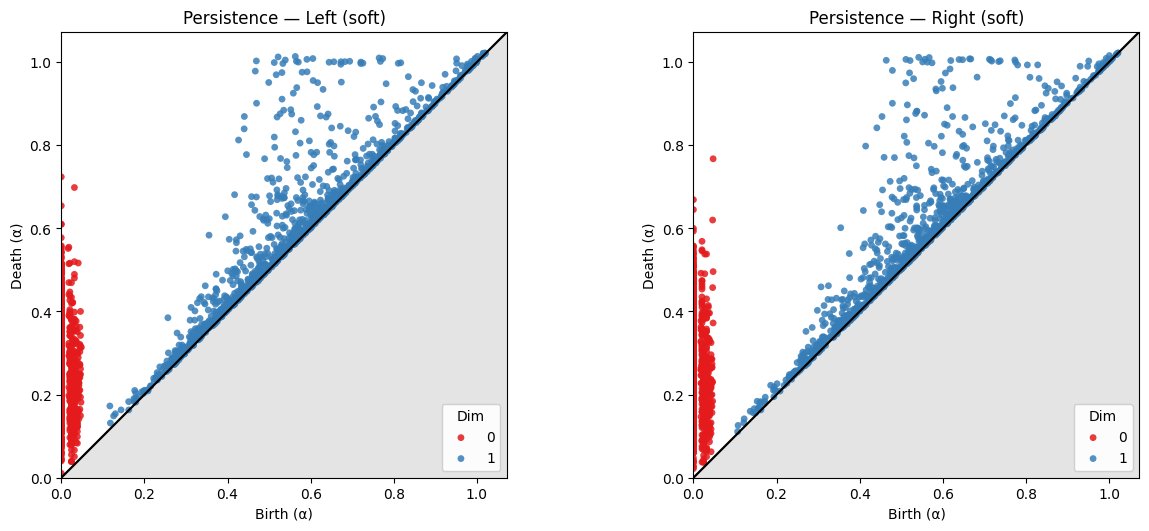

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.patches import Polygon
from typing import Dict, Tuple, List, Optional


class ChiralPH2D:
    """
    Chiral persistent homology on 2D point sets (Alpha complex).

    - mode='soft': same simplices; parity-weighted birth times.
    - mode='hard': keep only triangles of chosen parity (stronger effect).
    - Robust α² normalization via percentiles; plots in α (sqrt of α²).
    - Bottleneck/Wasserstein distances + permutation test for H1.
    """

    def __init__(self,
                 points: np.ndarray,
                 max_alpha: Optional[float] = None,   # cutoff in α (None = no cut)
                 lambda_rel: float = 0.06,
                 drop_infinite: bool = True,
                 p_lo: float = 5.0, p_hi: float = 95.0,
                 mode: str = "soft"):
        P = np.asarray(points, float)
        assert P.ndim == 2 and P.shape[1] >= 2, "points must be (N,>=2)"
        self.XY = P[:, :2]
        self.max_alpha2 = None if max_alpha is None else float(max_alpha) ** 2
        self.lambda_rel = float(lambda_rel)
        self.drop_inf = bool(drop_infinite)
        assert 0 <= p_lo < p_hi <= 100
        self.p_lo, self.p_hi = float(p_lo), float(p_hi)
        assert mode in ("soft", "hard")
        self.mode = mode

    # ---------- Alpha complex & extraction ----------
    def _alpha_tree(self) -> gd.SimplexTree:
        return gd.AlphaComplex(points=self.XY).create_simplex_tree()

    def _extract_up_to_dim2(self, st: gd.SimplexTree):
        V: Dict[int, float] = {}
        E: Dict[Tuple[int, int], float] = {}
        T: List[Tuple[int, int, int, float]] = []
        for s, a2 in st.get_skeleton(2):
            a2 = float(a2)
            d = len(s) - 1
            if d == 0:
                V[int(s[0])] = a2
            elif d == 1:
                i, j = sorted(map(int, s)); E[(i, j)] = a2
            elif d == 2:
                i, j, k = map(int, s)
                if (self.max_alpha2 is None) or (a2 <= self.max_alpha2):
                    T.append((i, j, k, a2))
        return V, E, T

    @staticmethod
    def _canon_signed_area(tri_xy: np.ndarray) -> float:
        t = np.asarray(tri_xy)
        o = np.lexsort((t[:, 1], t[:, 0]))  # deterministic by x then y
        p0, p1, p2 = t[o]
        v1, v2 = p1 - p0, p2 - p0
        return v1[0] * v2[1] - v1[1] * v2[0]

    # ---------- Parity scores ----------
    def _vertex_parity_scores(self, tris_a2):
        acc = {}  # v -> (sum, count)
        for i, j, k, _ in tris_a2:
            s = np.sign(self._canon_signed_area(self.XY[[i, j, k]]))
            if s == 0:  # degenerate
                continue
            for v in (i, j, k):
                su, c = acc.get(v, (0.0, 0))
                acc[v] = (su + s, c + 1)
        return {v: su / c for v, (su, c) in acc.items()}  # S_v in [-1,1]

    def _vertex_parity_scores_raw(self):
        """Same as above but recomputes T internally; handy for permutation test."""
        _, _, T = self._extract_up_to_dim2(self._alpha_tree())
        return self._vertex_parity_scores(T)

    # ---------- Build LH / RH filtrations ----------
    def _build_LH_RH_trees(self, S_override: Optional[Dict[int, float]] = None):
        st_full = self._alpha_tree()
        V, E, T = self._extract_up_to_dim2(st_full)

        # robust percentile normalization for α² -> [0,1]
        base_vals = np.array([*V.values(), *E.values(), *[a2 for *_, a2 in T]] or [0.0, 1.0], float)
        plo, phi = np.percentile(base_vals, [self.p_lo, self.p_hi])
        lo, span = float(plo), max(float(phi - plo), 1e-12)
        clip01 = lambda x: np.clip((x - lo) / span, 0.0, 1.0)
        Vn = {i: clip01(a2) for i, a2 in V.items()}
        En = {e: clip01(a2) for e, a2 in E.items()}
        Tn = [(i, j, k, clip01(a2)) for (i, j, k, a2) in T]

        # triangle handedness (for 'hard' mode)
        tri_sign = {}
        for i, j, k, _ in T:
            s = int(np.sign(self._canon_signed_area(self.XY[[i, j, k]])))
            if s != 0:
                tri_sign[tuple(sorted((i, j, k)))] = s

        # vertex parity scores (soft mode / permutation)
        Sv = S_override if S_override is not None else self._vertex_parity_scores(T)
        def simplex_score(simplex):
            return float(np.mean([Sv.get(v, 0.0) for v in simplex]))

        lam = self.lambda_rel

        def build(sign: int):  # sign = +1 (RH) or -1 (LH)
            st = gd.SimplexTree()
            # vertices (tiny bias for soft mode only)
            for v, a2 in Vn.items():
                bias = (lam * 0.05 * Sv.get(v, 0.0)) if self.mode == "soft" else 0.0
                st.insert([v], filtration=max(0.0, a2 - sign * bias))
            # edges (present in both; shift only in soft mode)
            edge_f = {}
            for (i, j), a2 in En.items():
                s_soft = simplex_score((i, j)) if self.mode == "soft" else 0.0
                a2p = max(0.0, a2 - sign * lam * s_soft)
                st.insert([i, j], filtration=a2p)
                edge_f[(min(i, j), max(i, j))] = a2p
            # triangles
            for i, j, k, a2 in Tn:
                tri = tuple(sorted((i, j, k)))
                keep = (tri_sign.get(tri, 0) == sign) if self.mode == "hard" else True
                if not keep:
                    continue
                s_soft = simplex_score((i, j, k)) if self.mode == "soft" else 0.0
                a2p = max(0.0, a2 - sign * lam * s_soft)
                e1 = edge_f[(min(i, j), max(i, j))]
                e2 = edge_f[(min(j, k), max(j, k))]
                e3 = edge_f[(min(i, k), max(i, k))]
                st.insert([i, j, k], filtration=max(a2p, e1, e2, e3))
            st.make_filtration_non_decreasing()
            return st

        RH = build(+1); LH = build(-1)
        return LH, RH

    # ---------- Persistence / distances ----------
    @staticmethod
    def _pd(st: gd.SimplexTree, drop_inf=True):
        pd = st.persistence()
        return [(d, (b, de)) for d, (b, de) in pd if (not drop_inf) or np.isfinite(de)]

    def chiral_persistence(self):
        LH_st, RH_st = self._build_LH_RH_trees()
        return self._pd(LH_st, self.drop_inf), self._pd(RH_st, self.drop_inf)

    @staticmethod
    def _pairs(diag, k):
        return [bd for d, bd in diag if d == k]

    def bottleneck_distance(self):
        LH, RH = self.chiral_persistence()
        return {k: gd.bottleneck_distance(self._pairs(LH, k), self._pairs(RH, k)) for k in (0, 1)}

    def wasserstein_distance(self, q=1.0):
        import gudhi.wasserstein as ws
        LH, RH = self.chiral_persistence()
        def arr(diag, k):
            A = np.array(self._pairs(diag, k), float)
            return A if A.size else np.empty((0, 2))
        return {k: ws.wasserstein_distance(arr(LH, k), arr(RH, k), order=q) for k in (0, 1)}

    # ---------- Permutation test (H1) ----------
    def permutation_test(self, n_perm=200, q=1.0, random_state=0):
        """
        Shuffle vertex parity scores S_v across vertices, recompute H1 Wasserstein
        for LH vs RH, and return {'obs','null_mean','null_std','z','p_one_sided'}.
        """
        import gudhi.wasserstein as ws
        rng = np.random.default_rng(random_state)

        # observed
        LH, RH = self._build_LH_RH_trees()
        A = np.array(self._pairs(self._pd(LH, True), 1), float)
        B = np.array(self._pairs(self._pd(RH, True), 1), float)
        obs = float(ws.wasserstein_distance(A if A.size else np.empty((0, 2)),
                                            B if B.size else np.empty((0, 2)),
                                            order=q))
        # vertex scores and permutation
        Sv = self._vertex_parity_scores_raw()
        verts = np.arange(self.XY.shape[0])
        Sv_vals = np.array([Sv.get(int(v), 0.0) for v in verts], float)

        sims = []
        for _ in range(int(n_perm)):
            rng.shuffle(Sv_vals)
            S_perm = {int(v): Sv_vals[i] for i, v in enumerate(verts)}
            LH_p, RH_p = self._build_LH_RH_trees(S_override=S_perm)
            Ap = np.array(self._pairs(self._pd(LH_p, True), 1), float)
            Bp = np.array(self._pairs(self._pd(RH_p, True), 1), float)
            sims.append(ws.wasserstein_distance(Ap if Ap.size else np.empty((0, 2)),
                                                Bp if Bp.size else np.empty((0, 2)),
                                                order=q))
        sims = np.array(sims, float)
        mu = float(sims.mean()) if sims.size else 0.0
        sd = float(sims.std(ddof=1)) if sims.size > 1 else 0.0
        z = (obs - mu) / sd if sd > 1e-12 else float("inf")
        p = float(np.mean(sims >= obs)) if sims.size else 1.0
        return {"obs": obs, "null_mean": mu, "null_std": sd, "z": float(z), "p_one_sided": p}

    # ---------- Plotting in α (sqrt of α²) ----------
    @staticmethod
    def _plot_pd_alpha(ax, diag, title="Persistence", units="α"):
        to_alpha = lambda A: np.sqrt(np.clip(A, 0.0, np.inf))
        pts = np.array([bd for _, bd in diag], float)
        if pts.size:
            pts = to_alpha(pts)
            lo, hi = float(pts.min()), float(pts.max())
            pad = 0.05 * (hi - lo + 1e-12)
            xlim = (max(0.0, lo - pad), hi + pad)
        else:
            xlim = (0.0, 1.0)
        ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k-', lw=1.6)
        ax.add_patch(Polygon([[xlim[0], xlim[0]], [xlim[1], xlim[0]], [xlim[1], xlim[1]]],
                             closed=True, facecolor="#d3d3d3", edgecolor="none", alpha=0.6))
        for k, color in [(0, "#e41a1c"), (1, "#377eb8")]:
            A = np.array([bd for d, bd in diag if d == k], float)
            if A.size:
                A = to_alpha(A)
                m = np.isfinite(A[:, 1])
                ax.scatter(A[m, 0], A[m, 1], s=24, alpha=0.85, c=color, edgecolors="none", label=str(k))
        ax.set_xlim(xlim); ax.set_ylim(xlim); ax.set_aspect("equal")
        ax.set_xlabel(f"Birth ({units})"); ax.set_ylabel(f"Death ({units})")
        ax.legend(loc="lower right", title="Dim", framealpha=0.9)
        ax.set_title(title)

    def plot(self):
        LH, RH = self.chiral_persistence()
        fig, axs = plt.subplots(1, 2, figsize=(12.6, 5.2), constrained_layout=True)
        self._plot_pd_alpha(axs[0], LH, f"Persistence — Left ({self.mode})")
        self._plot_pd_alpha(axs[1], RH, f"Persistence — Right ({self.mode})")
        plt.show()


# ---------------- Demo ----------------
if __name__ == "__main__":
    np.random.seed(0)
    pts = np.random.uniform(-1, 1, size=(1000, 2))

    # SOFT: nudged times (subtle on parity-neutral data)
    ch = ChiralPH2D(pts, lambda_rel=0.06, mode="soft", p_lo=5, p_hi=95)
    print("Bottleneck:", ch.bottleneck_distance())
    print("Wasserstein:", ch.wasserstein_distance())
    print("Permutation test (H1):", ch.permutation_test(n_perm=200, q=1.0))
    ch.plot()

    # HARD: keep only triangles of chosen parity (stronger visual split)
    # ch_hard = ChiralPH2D(pts, lambda_rel=0.06, mode="hard", p_lo=5, p_hi=95)
    # print("Wasserstein (hard):", ch_hard.wasserstein_distance())
    # ch_hard.plot()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.patches import Polygon
from typing import Dict, Tuple, List, Optional


class ChiralPH3D:
    """
    Chiral persistent homology on 3D point sets (Alpha complex).

    - mode='soft': same simplices; parity-weighted births (valid filtration).
    - mode='hard': keep only tetrahedra of chosen parity (stronger effect).
    - Robust α² normalization via percentiles; PDs are plotted in α (sqrt α²).
    - Distances for dims 0,1,2; permutation test on H2.
    """

    def __init__(
        self,
        points: np.ndarray,
        max_alpha: Optional[float] = None,   # cutoff in α (None=no cut)
        lambda_rel: float = 0.06,
        drop_infinite: bool = True,
        p_lo: float = 5.0,
        p_hi: float = 95.0,
        mode: str = "soft",
    ):
        P = np.asarray(points, float)
        assert P.ndim == 2 and P.shape[1] >= 3, "points must be (N,>=3)"
        self.XYZ = P[:, :3]
        self.max_alpha2 = None if max_alpha is None else float(max_alpha) ** 2
        self.lambda_rel = float(lambda_rel)
        self.drop_inf = bool(drop_infinite)
        assert 0 <= p_lo < p_hi <= 100
        self.p_lo, self.p_hi = float(p_lo), float(p_hi)
        assert mode in ("soft", "hard")
        self.mode = mode

    # ---------- Alpha complex & extraction ----------
    def _alpha_tree(self) -> gd.SimplexTree:
        return gd.AlphaComplex(points=self.XYZ).create_simplex_tree()

    def _extract_up_to_dim3(self, st: gd.SimplexTree):
        V: Dict[int, float] = {}
        E: Dict[Tuple[int, int], float] = {}
        F: Dict[Tuple[int, int, int], float] = {}
        T: List[Tuple[int, int, int, int, float]] = []  # tetra + alpha^2
        for s, a2 in st.get_skeleton(3):
            a2 = float(a2)
            d = len(s) - 1
            if d == 0:
                V[int(s[0])] = a2
            elif d == 1:
                i, j = sorted(map(int, s)); E[(i, j)] = a2
            elif d == 2:
                i, j, k = sorted(map(int, s)); F[(i, j, k)] = a2
            elif d == 3:
                i, j, k, l = map(int, s)
                if (self.max_alpha2 is None) or (a2 <= self.max_alpha2):
                    T.append((i, j, k, l, a2))
        return V, E, F, T

    # ---------- Orientation / parity ----------
    @staticmethod
    def _signed_volume(p0, p1, p2, p3) -> float:
        v1, v2, v3 = p1 - p0, p2 - p0, p3 - p0
        return np.linalg.det(np.c_[v1, v2, v3]) / 6.0

    def _canonical_tetra_sign(self, tet_idx) -> int:
        pts = self.XYZ[np.array(tet_idx)]
        o = np.lexsort((pts[:, 2], pts[:, 1], pts[:, 0]))  # stable by (x,y,z)
        p0, p1, p2, p3 = pts[o]
        return int(np.sign(self._signed_volume(p0, p1, p2, p3)))

    def _vertex_parity_scores(self, T):
        acc = {}  # v -> (sum, count)
        for i, j, k, l, _ in T:
            s = self._canonical_tetra_sign((i, j, k, l))
            if s == 0:
                continue
            for v in (i, j, k, l):
                su, c = acc.get(v, (0.0, 0))
                acc[v] = (su + s, c + 1)
        return {v: su / c for v, (su, c) in acc.items()}  # in [-1,1]

    # ---------- Build LH/RH filtrations ----------
    def _build_LH_RH_trees(self, S_override: Optional[Dict[int, float]] = None):
        st_full = self._alpha_tree()
        V, E, F, T = self._extract_up_to_dim3(st_full)

        # robust percentile normalization α² -> [0,1]
        base_vals = np.array([*V.values(), *E.values(), *F.values(), *[a2 for *_, a2 in T]] or [0.0, 1.0], float)
        plo, phi = np.percentile(base_vals, [self.p_lo, self.p_hi])
        lo, span = float(plo), max(float(phi - plo), 1e-12)
        norm = lambda x: np.clip((x - lo) / span, 0.0, 1.0)

        Vn = {i: norm(a2) for i, a2 in V.items()}
        En = {e: norm(a2) for e, a2 in E.items()}
        Fn = {f: norm(a2) for f, a2 in F.items()}
        Tn = [(i, j, k, l, norm(a2)) for (i, j, k, l, a2) in T]

        tet_sign = {}
        for i, j, k, l, _ in T:
            s = self._canonical_tetra_sign((i, j, k, l))
            if s != 0:
                tet_sign[tuple(sorted((i, j, k, l)))] = s

        Sv = S_override if S_override is not None else self._vertex_parity_scores(T)
        score = lambda simplex: float(np.mean([Sv.get(v, 0.0) for v in simplex]))
        lam = self.lambda_rel

        def build(sign: int):  # +1 RH, -1 LH
            st = gd.SimplexTree()

            # vertices
            for v, a2 in Vn.items():
                bias = lam * 0.05 * Sv.get(v, 0.0) if self.mode == "soft" else 0.0
                st.insert([v], filtration=max(0.0, a2 - sign * bias))

            # edges
            edge_f = {}
            for (i, j), a2 in En.items():
                a2p = max(0.0, a2 - sign * lam * (score((i, j)) if self.mode == "soft" else 0.0))
                a2p = max(a2p, Vn[i], Vn[j])
                st.insert([i, j], filtration=a2p)
                edge_f[(min(i, j), max(i, j))] = a2p

            # triangles
            tri_f = {}
            for (i, j, k), a2 in Fn.items():
                a2p = max(0.0, a2 - sign * lam * (score((i, j, k)) if self.mode == "soft" else 0.0))
                e1 = edge_f[(min(i, j), max(i, j))]
                e2 = edge_f[(min(j, k), max(j, k))]
                e3 = edge_f[(min(i, k), max(i, k))]
                a2p = max(a2p, e1, e2, e3)
                st.insert([i, j, k], filtration=a2p)
                tri_f[tuple(sorted((i, j, k)))] = a2p

            # tetrahedra
            for i, j, k, l, a2 in Tn:
                if self.mode == "hard":
                    if tet_sign.get(tuple(sorted((i, j, k, l))), 0) != sign:
                        continue
                a2p = max(0.0, a2 - sign * lam * (score((i, j, k, l)) if self.mode == "soft" else 0.0))
                f1 = tri_f[tuple(sorted((i, j, k)))]
                f2 = tri_f[tuple(sorted((i, j, l)))]
                f3 = tri_f[tuple(sorted((i, k, l)))]
                f4 = tri_f[tuple(sorted((j, k, l)))]
                a2p = max(a2p, f1, f2, f3, f4)
                st.insert([i, j, k, l], filtration=a2p)

            st.make_filtration_non_decreasing()
            return st

        RH = build(+1); LH = build(-1)
        return LH, RH

    # ---------- Persistence / distances ----------
    @staticmethod
    def _pd(st: gd.SimplexTree, drop_inf=True):
        pd = st.persistence()
        return [(d, (b, de)) for d, (b, de) in pd if (not drop_inf) or np.isfinite(de)]

    def chiral_persistence(self):
        LH_st, RH_st = self._build_LH_RH_trees()
        return self._pd(LH_st, self.drop_inf), self._pd(RH_st, self.drop_inf)

    @staticmethod
    def _pairs(diag, k):
        return [bd for d, bd in diag if d == k]

    def bottleneck_distance(self):
        LH, RH = self.chiral_persistence()
        return {k: gd.bottleneck_distance(self._pairs(LH, k), self._pairs(RH, k)) for k in (0, 1, 2)}

    def wasserstein_distance(self, q=1.0):
        import gudhi.wasserstein as ws
        LH, RH = self.chiral_persistence()
        def arr(diag, k):
            A = np.array(self._pairs(diag, k), float)
            return A if A.size else np.empty((0, 2))
        return {k: ws.wasserstein_distance(arr(LH, k), arr(RH, k), order=q) for k in (0, 1, 2)}

    # ---------- Permutation test (H2) ----------
    def permutation_test_H2(self, n_perm=200, q=1.0, random_state=0):
        import gudhi.wasserstein as ws
        rng = np.random.default_rng(random_state)

        LH, RH = self._build_LH_RH_trees()
        A = np.array(self._pairs(self._pd(LH, True), 2), float)
        B = np.array(self._pairs(self._pd(RH, True), 2), float)
        obs = float(ws.wasserstein_distance(A if A.size else np.empty((0, 2)),
                                            B if B.size else np.empty((0, 2)), order=q))

        _, _, _, T = self._extract_up_to_dim3(self._alpha_tree())
        Sv = self._vertex_parity_scores(T)
        verts = np.arange(self.XYZ.shape[0])
        Sv_vals = np.array([Sv.get(int(v), 0.0) for v in verts], float)

        sims = []
        for _ in range(int(n_perm)):
            rng.shuffle(Sv_vals)
            S_perm = {int(v): Sv_vals[i] for i, v in enumerate(verts)}
            LH_p, RH_p = self._build_LH_RH_trees(S_override=S_perm)
            Ap = np.array(self._pairs(self._pd(LH_p, True), 2), float)
            Bp = np.array(self._pairs(self._pd(RH_p, True), 2), float)
            sims.append(ws.wasserstein_distance(Ap if Ap.size else np.empty((0, 2)),
                                                Bp if Bp.size else np.empty((0, 2)), order=q))
        sims = np.array(sims, float)
        mu = float(sims.mean()) if sims.size else 0.0
        sd = float(sims.std(ddof=1)) if sims.size > 1 else 0.0
        z = (obs - mu) / sd if sd > 1e-12 else float("inf")
        p = float(np.mean(sims >= obs)) if sims.size else 1.0
        return {"obs": obs, "null_mean": mu, "null_std": sd, "z": float(z), "p_one_sided": p}

    # ---------- Plotting (fixed): 3×2 grid ----------
    def _plot_pd_alpha_one(self, ax, diag, dim, title):
        to_alpha = lambda A: np.sqrt(np.clip(A, 0.0, np.inf))
        A = np.array(self._pairs(diag, dim), float)
        if A.size:
            A = to_alpha(A)
            lo, hi = float(A.min()), float(A.max())
            pad = 0.05 * (hi - lo + 1e-12)
            xlim = (max(0.0, lo - pad), hi + pad)
        else:
            xlim = (0.0, 1.0)

        ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k-', lw=1.6)
        ax.add_patch(Polygon([[xlim[0], xlim[0]], [xlim[1], xlim[0]], [xlim[1], xlim[1]]],
                             closed=True, facecolor="#d3d3d3", edgecolor="none", alpha=0.6))

        if A.size:
            color = {0: "#e41a1c", 1: "#377eb8", 2: "#4daf4a"}[dim]
            ax.scatter(A[:, 0], A[:, 1], s=18, alpha=0.85, c=color, edgecolors="none", label=f"H{dim}")
            ax.legend(loc="lower right", framealpha=0.9)

        ax.set_xlim(xlim); ax.set_ylim(xlim); ax.set_aspect("equal")
        ax.set_xlabel("Birth (α)"); ax.set_ylabel("Death (α)")
        ax.set_title(title)

    def plot(self):
        LH, RH = self.chiral_persistence()
        fig, axs = plt.subplots(3, 2, figsize=(12.5, 12), constrained_layout=True)
        sides = [("Left", LH), ("Right", RH)]
        for col, (name, diag) in enumerate(sides):
            for row, dim in enumerate((0, 1, 2)):
                self._plot_pd_alpha_one(axs[row, col], diag, dim, f"{name} — H{dim}")
        plt.show()


# ---------------- Demo ----------------
if __name__ == "__main__":
    np.random.seed(0)
    pts3d = np.random.uniform(-1, 1, size=(1500, 3))

    ch = ChiralPH3D(pts3d, lambda_rel=0.06, mode="soft", p_lo=5, p_hi=95)
    print("Bottleneck:", ch.bottleneck_distance())
    print("Wasserstein:", ch.wasserstein_distance())
    print("Permutation (H2):", ch.permutation_test_H2(n_perm=200, q=1.0))
    ch.plot()

    # Stronger split:
    # ch_hard = ChiralPH3D(pts3d, lambda_rel=0.06, mode="hard", p_lo=5, p_hi=95)
    # ch_hard.plot()


Bottleneck: {0: 0.004045786431598905, 1: 0.014498850796905827, 2: 0.008825953126062677}


ModuleNotFoundError: No module named 'ot'

Wasserstein (hard): {0: np.float64(0.0), 1: np.float64(0.0), 2: np.float64(0.2731120138836448)}
Permutation H2 (hard): {'obs': 0.2731120138836448, 'null_mean': 0.27311201388364476, 'null_std': 5.565045170431277e-17, 'z': inf, 'p_one_sided': 1.0}


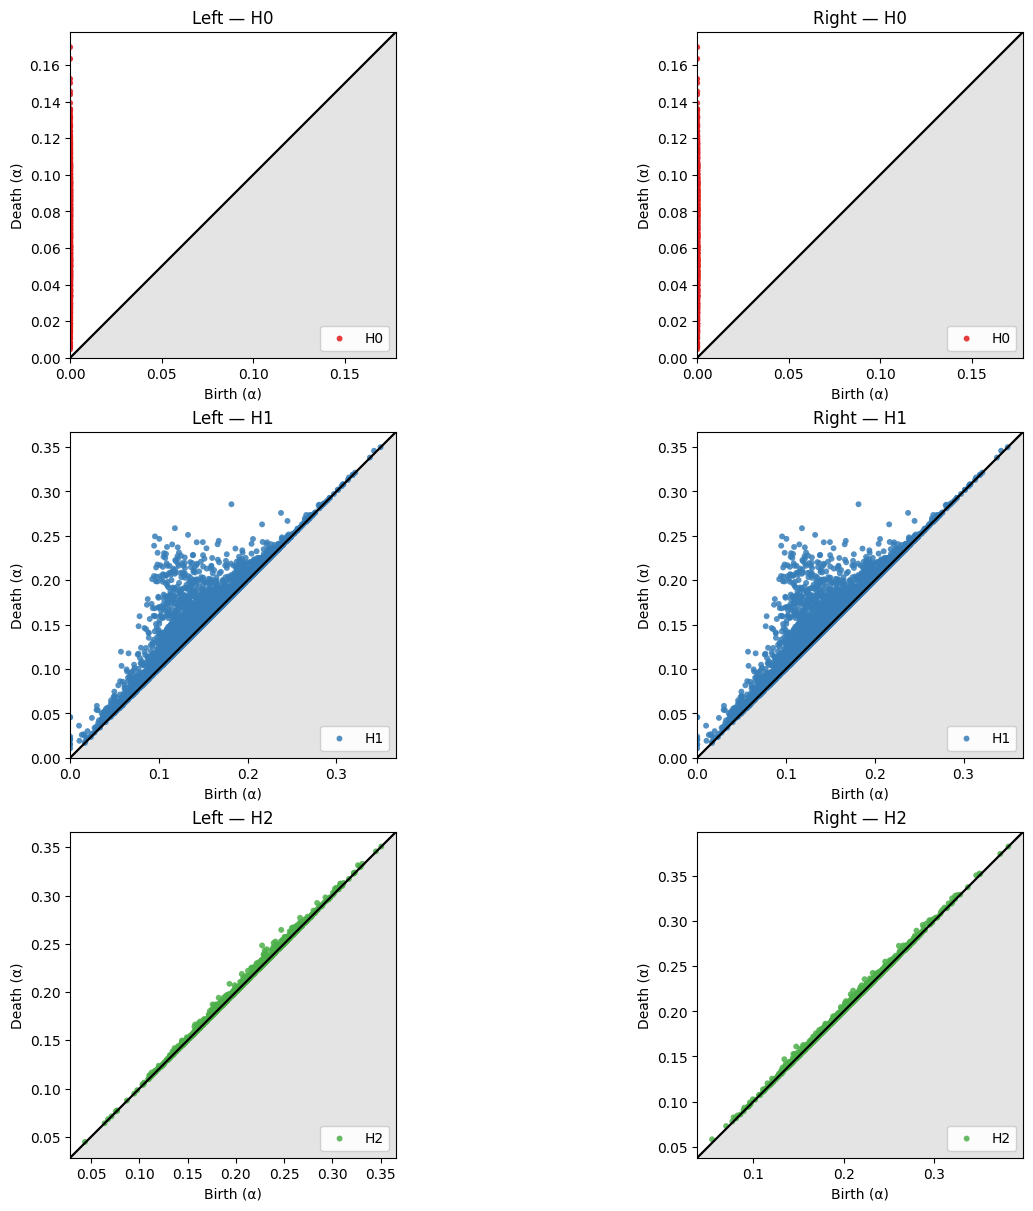

In [9]:
ch_hard = ChiralPH3D(pts3d, lambda_rel=0.06, mode="hard", p_lo=5, p_hi=95)
print("Wasserstein (hard):", ch_hard.wasserstein_distance())
print("Permutation H2 (hard):", ch_hard.permutation_test_H2(n_perm=200))
ch_hard.plot()


Helix vs mirror — Wasserstein: {0: np.float64(0.0685879310513162), 1: np.float64(0.9521276143754321), 2: np.float64(0.927370476284014)} {0: np.float64(0.06858793105131622), 1: np.float64(0.9521276143754321), 2: np.float64(0.9273704762840135)}


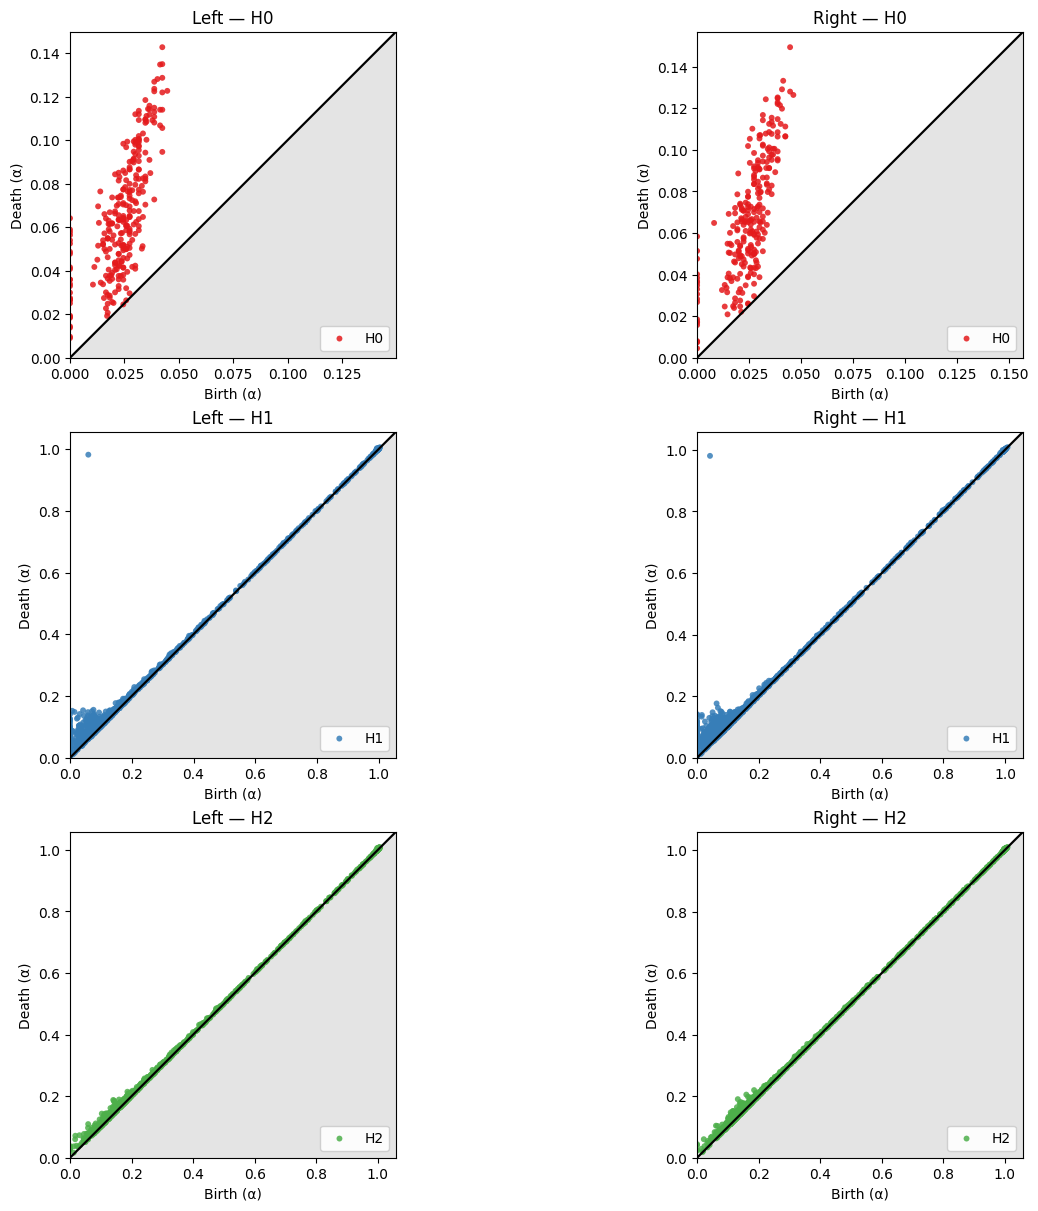

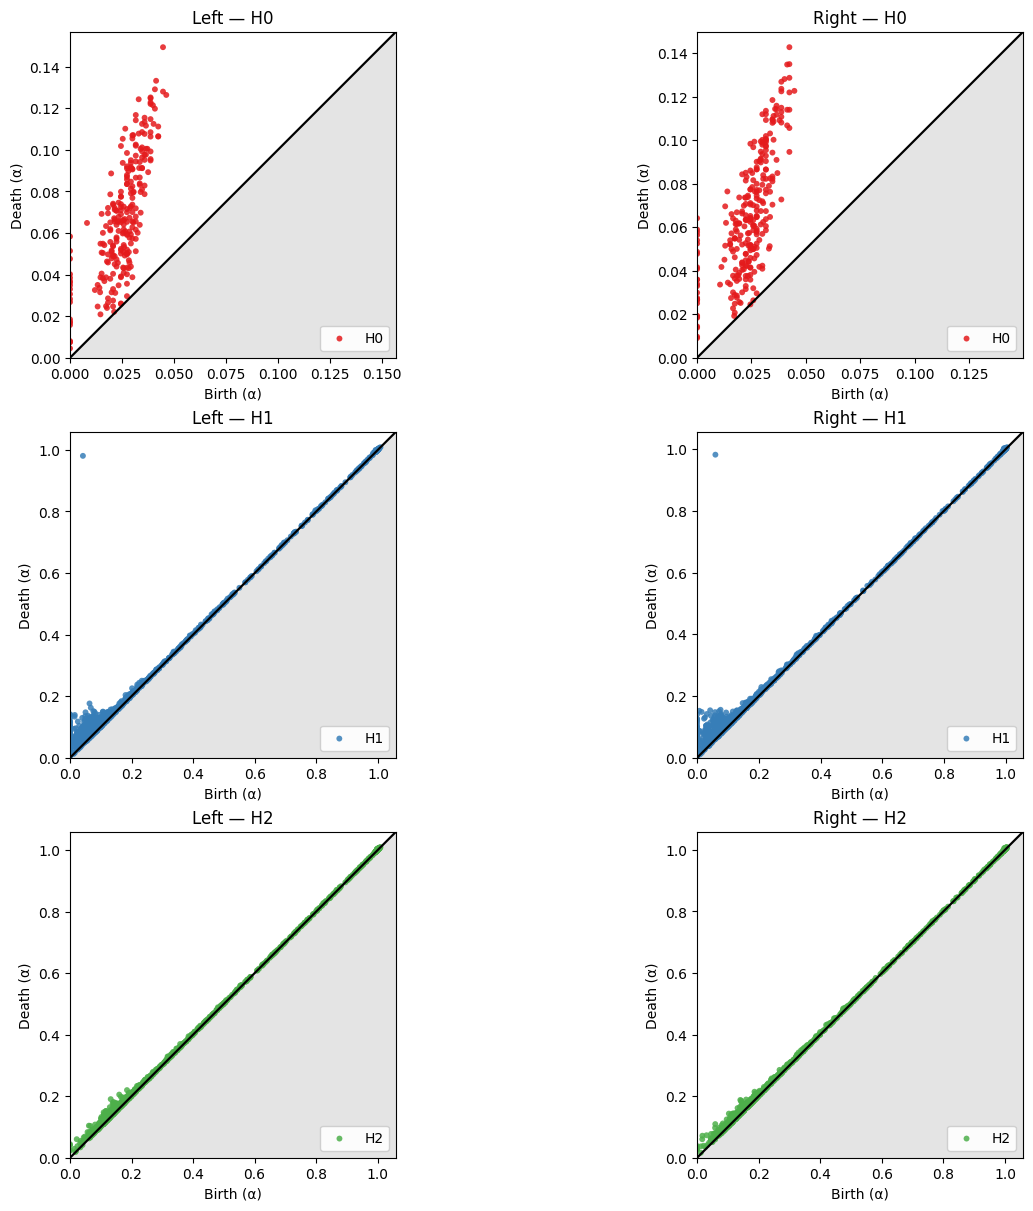

In [10]:
def helix(n=1200, turns=4, radius=1.0, pitch=0.2, noise=0.02, seed=0):
    rng = np.random.default_rng(seed)
    t = np.linspace(0, 2*np.pi*turns, n)
    x = radius*np.cos(t) + rng.normal(0, noise, n)
    y = radius*np.sin(t) + rng.normal(0, noise, n)
    z = pitch * t/(2*np.pi) + rng.normal(0, noise, n)
    return np.c_[x, y, z]

def mirror_x(P):
    Q = P.copy()
    Q[:,0] *= -1
    return Q

H   = helix()
H_m = mirror_x(H)

chL = ChiralPH3D(H,   lambda_rel=0.06, mode="soft")
chR = ChiralPH3D(H_m, lambda_rel=0.06, mode="soft")
print("Helix vs mirror — Wasserstein:", chL.wasserstein_distance(), chR.wasserstein_distance())
chL.plot(); chR.plot()


In [11]:
for lam in (0.06, 0.08, 0.10):
    ch = ChiralPH3D(pts3d, lambda_rel=lam, mode="soft", p_lo=5, p_hi=95)
    print(f"λ={lam}: W₂:", ch.wasserstein_distance())
    print(f"λ={lam}: perm H2:", ch.permutation_test_H2(n_perm=200))


λ=0.06: W₂: {0: np.float64(0.40170540906284746), 1: np.float64(2.139168896284804), 2: np.float64(1.6656383349832984)}
λ=0.06: perm H2: {'obs': 1.6656383349832984, 'null_mean': 1.7157504767228027, 'null_std': 0.04965138418174938, 'z': -1.0092798532276221, 'p_one_sided': 0.85}
λ=0.08: W₂: {0: np.float64(0.43348752054963857), 1: np.float64(2.4478523309640425), 2: np.float64(1.9180108963593483)}
λ=0.08: perm H2: {'obs': 1.9180108963593483, 'null_mean': 1.9562456206299879, 'null_std': 0.0690598528791613, 'z': -0.5536461877140318, 'p_one_sided': 0.72}
λ=0.1: W₂: {0: np.float64(0.44834582331444156), 1: np.float64(2.6911362260668334), 2: np.float64(2.1411187436794203)}
λ=0.1: perm H2: {'obs': 2.1411187436794203, 'null_mean': 2.17686297666162, 'null_std': 0.08355715050084088, 'z': -0.42778185670464935, 'p_one_sided': 0.645}


In [12]:
def lifetimes(diag, dim):
    return [d-b for (b,d) in (bd for D,bd in diag if D==dim)]
LH, RH = ch.chiral_persistence()
for k in (1,2):
    l, r = lifetimes(LH,k), lifetimes(RH,k)
    print(f"H{k} median (LH,RH):", np.median(l), np.median(r),
          "| mean:", np.mean(l), np.mean(r))


H1 median (LH,RH): 0.003618181539729202 0.0034965034965034943 | mean: 0.005971678437488159 0.0059159358787394985
H2 median (LH,RH): 0.0023145504823703124 0.0023051125382593657 | mean: 0.0040990150712038025 0.0038838364950727826
